In [0]:
!pip install xgboost

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Scikit-learn imports for models and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve

# XGBoost import

import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("All imports successful!")
print("Ready for model training pipeline")

✅ All imports successful!
Ready for model training pipeline


In [0]:
print("=== LOADING ENGINEERED FEATURES ===")

# Load from your engineered features file
features_df = spark.read.option("header", "true").option("inferSchema", "true").csv("/Volumes/workspace/default/project/engineered_features/part-00000-tid-6184557731404669919-21325f2a-518d-4ed9-9325-cb590e7db15d-903-1-c000.csv")

print(f"Features loaded: {features_df.count()} customers, {len(features_df.columns)} features")

# Show sample of the data
print("\nFeature Data Preview:")
features_df.show(5)

# Check for any missing values
print("\nMissing Values Check:")
missing_counts = features_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in features_df.columns
])
missing_counts.show()

=== LOADING ENGINEERED FEATURES ===
Features loaded: 290 customers, 31 features

Feature Data Preview:
+------------------+------------------+--------------------+--------------------+--------------------+------------------+---------------------------------+----------------+----------------------+----------+-----------------+--------------------------+------------------------------+-----------------------------------+------------------+-------------------+-----------------+------------------------+--------------------+----------------------+-------------------+------------+---------------------+------------------+---------------+-------------------+------------------+----------------+-----------------+------+-----------+
|   avg_order_value|purchase_frequency|       recency_score|total_lifetime_value|customer_tenure_days| spending_velocity|order_value_coefficient_variation|last_order_month|last_order_day_of_week|is_weekend|is_holiday_season|preferred_category_encoded|preferred_payment_

In [0]:
print("=== PREPARING DATA FOR MODELING ===")

# Convert to Pandas for scikit-learn (small dataset assumption)
df_pandas = features_df.toPandas()

print(f"Pandas DataFrame shape: {df_pandas.shape}")

# Separate features and target
target_col = 'target'
id_col = 'customer_id'

# Remove non-feature columns
feature_columns = [col for col in df_pandas.columns if col not in [target_col, id_col]]

X = df_pandas[feature_columns]
y = df_pandas[target_col]

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Positive class rate: {y.mean():.3f}")

# Check for any remaining missing values and handle them
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
if X.isnull().sum().sum() > 0:
    print("Filling missing values with median...")
    X = X.fillna(X.median())

=== PREPARING DATA FOR MODELING ===
Pandas DataFrame shape: (290, 31)
Feature matrix shape: (290, 29)
Target distribution:
1    155
0    135
Name: target, dtype: int64
Positive class rate: 0.534

Missing values in features: 44
Filling missing values with median...


In [0]:
print("=== CREATING TRAIN-TEST SPLIT ===")

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"Training target distribution:")
print(y_train.value_counts(normalize=True))

print(f"Test target distribution:")
print(y_test.value_counts(normalize=True))

=== CREATING TRAIN-TEST SPLIT ===
Training set: 232 samples
Test set: 58 samples
Training target distribution:
1    0.534483
0    0.465517
Name: target, dtype: float64
Test target distribution:
1    0.534483
0    0.465517
Name: target, dtype: float64


In [0]:
print("=== FEATURE SCALING ===")

# Scale features for Logistic Regression (tree models don't need scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled for logistic regression")
print(f"Original feature range example: {X_train.iloc[:, 0].min():.2f} to {X_train.iloc[:, 0].max():.2f}")
print(f"Scaled feature range example: {X_train_scaled[:, 0].min():.2f} to {X_train_scaled[:, 0].max():.2f}")


=== FEATURE SCALING ===
Features scaled for logistic regression
Original feature range example: 1211.08 to 46362.64
Scaled feature range example: -2.77 to 2.40


In [0]:
print("=== TRAINING MODEL 1: LOGISTIC REGRESSION ===")

# Train Logistic Regression with regularization
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)

lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)
lr_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
lr_train_f1 = f1_score(y_train, lr_train_pred)
lr_test_f1 = f1_score(y_test, lr_test_pred)
lr_test_auc = roc_auc_score(y_test, lr_test_proba)

print(f"Logistic Regression Results:")
print(f"Train F1-Score: {lr_train_f1:.4f}")
print(f"Test F1-Score: {lr_test_f1:.4f}")
print(f"Test ROC-AUC: {lr_test_auc:.4f}")

=== TRAINING MODEL 1: LOGISTIC REGRESSION ===
Logistic Regression Results:
Train F1-Score: 0.6559
Test F1-Score: 0.5484
Test ROC-AUC: 0.5269


In [0]:
print("=== TRAINING MODEL 2: RANDOM FOREST ===")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)  # No scaling needed for tree models

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
rf_train_f1 = f1_score(y_train, rf_train_pred)
rf_test_f1 = f1_score(y_test, rf_test_pred)
rf_test_auc = roc_auc_score(y_test, rf_test_proba)

print(f"Random Forest Results:")
print(f"Train F1-Score: {rf_train_f1:.4f}")
print(f"Test F1-Score: {rf_test_f1:.4f}")
print(f"Test ROC-AUC: {rf_test_auc:.4f}")

=== TRAINING MODEL 2: RANDOM FOREST ===
Random Forest Results:
Train F1-Score: 1.0000
Test F1-Score: 0.6286
Test ROC-AUC: 0.5018


In [0]:
print("=== TRAINING MODEL 3: XGBOOST ===")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)
xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
xgb_train_f1 = f1_score(y_train, xgb_train_pred)
xgb_test_f1 = f1_score(y_test, xgb_test_pred)
xgb_test_auc = roc_auc_score(y_test, xgb_test_proba)

print(f"XGBoost Results:")
print(f"Train F1-Score: {xgb_train_f1:.4f}")
print(f"Test F1-Score: {xgb_test_f1:.4f}")
print(f"Test ROC-AUC: {xgb_test_auc:.4f}")

=== TRAINING MODEL 3: XGBOOST ===
XGBoost Results:
Train F1-Score: 1.0000
Test F1-Score: 0.5312
Test ROC-AUC: 0.4791


In [0]:
print("=== CROSS-VALIDATION EVALUATION ===")

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression CV
lr_cv_f1 = cross_val_score(lr_model, X_train_scaled, y_train, cv=cv, scoring='f1')
lr_cv_auc = cross_val_score(lr_model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')

# Random Forest CV
rf_cv_f1 = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='f1')
rf_cv_auc = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='roc_auc')

# XGBoost CV
xgb_cv_f1 = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='f1')
xgb_cv_auc = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='roc_auc')

print("Cross-Validation Results (5-fold):")
print("\nLogistic Regression:")
print(f"F1-Score: {lr_cv_f1.mean():.4f} (+/- {lr_cv_f1.std() * 2:.4f})")
print(f"ROC-AUC: {lr_cv_auc.mean():.4f} (+/- {lr_cv_auc.std() * 2:.4f})")

print("\nRandom Forest:")
print(f"F1-Score: {rf_cv_f1.mean():.4f} (+/- {rf_cv_f1.std() * 2:.4f})")
print(f"ROC-AUC: {rf_cv_auc.mean():.4f} (+/- {rf_cv_auc.std() * 2:.4f})")

print("\nXGBoost:")
print(f"F1-Score: {xgb_cv_f1.mean():.4f} (+/- {xgb_cv_f1.std() * 2:.4f})")
print(f"ROC-AUC: {xgb_cv_auc.mean():.4f} (+/- {xgb_cv_auc.std() * 2:.4f})")

=== CROSS-VALIDATION EVALUATION ===
Cross-Validation Results (5-fold):

Logistic Regression:
F1-Score: 0.5629 (+/- 0.1048)
ROC-AUC: 0.5455 (+/- 0.0563)

Random Forest:
F1-Score: 0.6001 (+/- 0.1774)
ROC-AUC: 0.5085 (+/- 0.1563)

XGBoost:
F1-Score: 0.5812 (+/- 0.1549)
ROC-AUC: 0.5390 (+/- 0.1064)


In [0]:
print("=== MODEL COMPARISON SUMMARY ===")

# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Test_F1_Score': [lr_test_f1, rf_test_f1, xgb_test_f1],
    'Test_ROC_AUC': [lr_test_auc, rf_test_auc, xgb_test_auc],
    'CV_F1_Mean': [lr_cv_f1.mean(), rf_cv_f1.mean(), xgb_cv_f1.mean()],
    'CV_F1_Std': [lr_cv_f1.std(), rf_cv_f1.std(), xgb_cv_f1.std()],
    'CV_AUC_Mean': [lr_cv_auc.mean(), rf_cv_auc.mean(), xgb_cv_auc.mean()],
    'CV_AUC_Std': [lr_cv_auc.std(), rf_cv_auc.std(), xgb_cv_auc.std()]
})

print("Model Performance Comparison:")
print(results_df.round(4))

# Determine best model
best_f1_model = results_df.loc[results_df['Test_F1_Score'].idxmax(), 'Model']
best_auc_model = results_df.loc[results_df['Test_ROC_AUC'].idxmax(), 'Model']

print(f"\nBest F1-Score: {best_f1_model}")
print(f"Best ROC-AUC: {best_auc_model}")

# Save results for next steps
model_results = {
    'lr_model': lr_model,
    'rf_model': rf_model, 
    'xgb_model': xgb_model,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'results_df': results_df
}

print("\n Model training and evaluation complete!")
print("Models saved for visualization and deployment steps.")

# ================================================================
# CELL 11: Detailed Classification Reports
# ================================================================

print("=== DETAILED CLASSIFICATION REPORTS ===")

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_test_pred))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_test_pred))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_test_pred))

=== MODEL COMPARISON SUMMARY ===
Model Performance Comparison:
                 Model  Test_F1_Score  ...  CV_AUC_Mean  CV_AUC_Std
0  Logistic Regression         0.5484  ...       0.5455      0.0281
1        Random Forest         0.6286  ...       0.5085      0.0782
2              XGBoost         0.5312  ...       0.5390      0.0532

[3 rows x 7 columns]

🏆 Best F1-Score: Random Forest
🏆 Best ROC-AUC: Logistic Regression

✅ Model training and evaluation complete!
Models saved for visualization and deployment steps.
=== DETAILED CLASSIFICATION REPORTS ===

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        27
           1       0.55      0.55      0.55        31

    accuracy                           0.52        58
   macro avg       0.51      0.51      0.51        58
weighted avg       0.52      0.52      0.52        58


Random Forest Classification Report:
              precision    rec

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib for better display
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(" Visualization setup complete!")
print("Ready to create required visualizations:")
print("1. ROC Curve comparison")
print("2. Feature Importance chart") 
print("3. Confusion Matrix")


✅ Visualization setup complete!
Ready to create required visualizations:
1. ROC Curve comparison
2. Feature Importance chart
3. Confusion Matrix


=== CREATING ROC CURVE COMPARISON ===


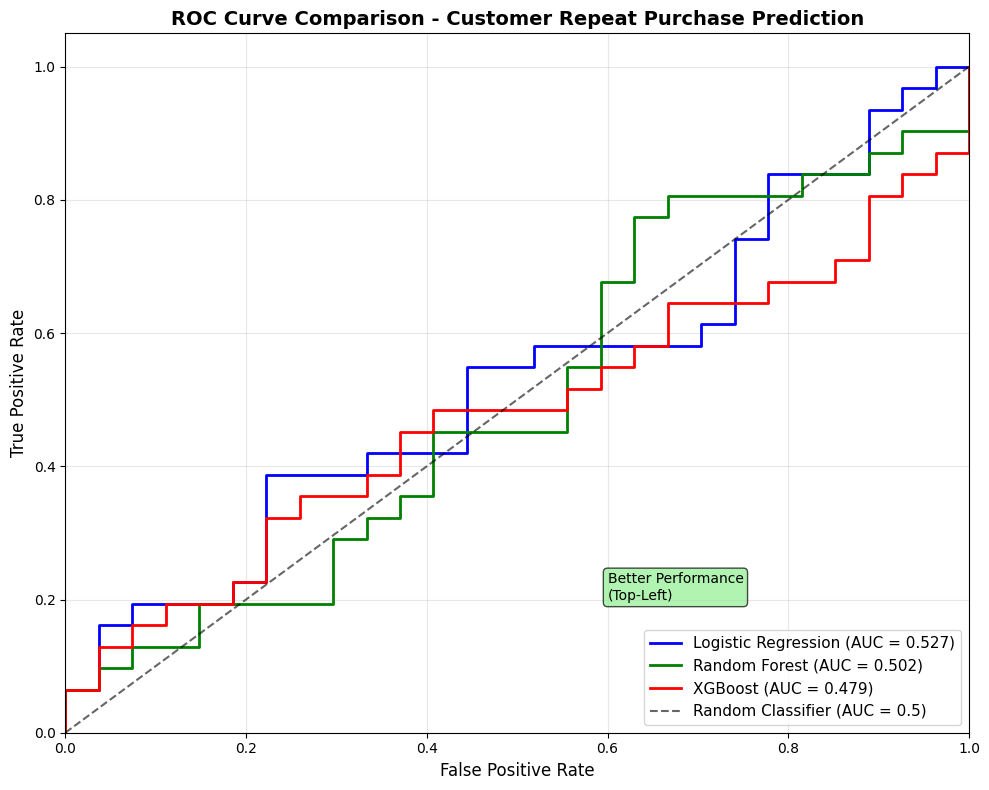

✅ ROC Curve comparison created!


In [0]:
print("=== CREATING ROC CURVE COMPARISON ===")

# Calculate ROC curves for all models
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_test_proba)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_test_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_test_proba)

# Create ROC curve plot
plt.figure(figsize=(10, 8))

# Plot each model's ROC curve
plt.plot(lr_fpr, lr_tpr, linewidth=2, label=f'Logistic Regression (AUC = {lr_test_auc:.3f})', color='blue')
plt.plot(rf_fpr, rf_tpr, linewidth=2, label=f'Random Forest (AUC = {rf_test_auc:.3f})', color='green')
plt.plot(xgb_fpr, xgb_tpr, linewidth=2, label=f'XGBoost (AUC = {xgb_test_auc:.3f})', color='red')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier (AUC = 0.5)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Customer Repeat Purchase Prediction', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# Add annotations
plt.text(0.6, 0.2, 'Better Performance\n(Top-Left)', fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

plt.tight_layout()
plt.show()

print(" ROC Curve comparison created!")

=== CREATING FEATURE IMPORTANCE CHART ===
Top 10 Most Important Features:
                              feature  importance
0                     avg_order_value    0.101443
2                       recency_score    0.098873
5                   spending_velocity    0.098848
4                customer_tenure_days    0.090516
6   order_value_coefficient_variation    0.087822
3                total_lifetime_value    0.079339
7                    last_order_month    0.065198
8              last_order_day_of_week    0.045566
1                  purchase_frequency    0.039053
11         preferred_category_encoded    0.033522


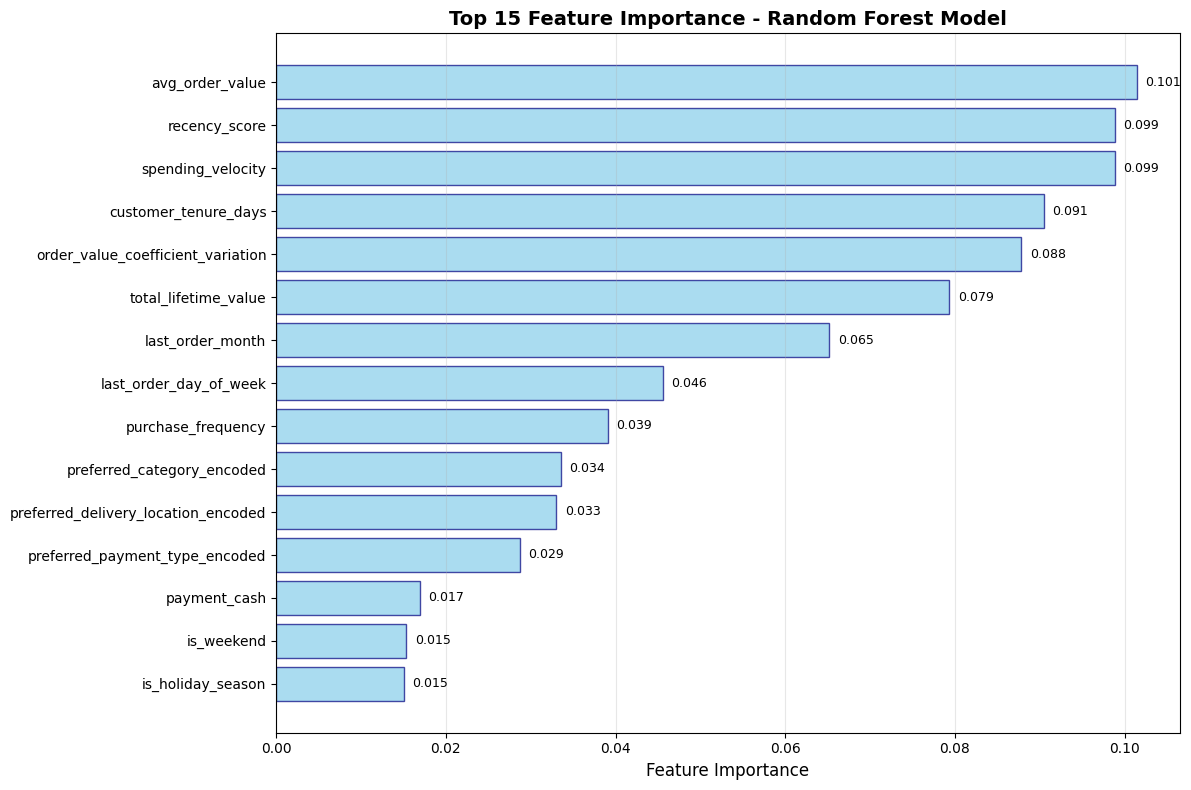


📊 KEY BUSINESS INSIGHTS:
Top 5 drivers of repeat purchases:
1. avg_order_value
2. recency_score
3. spending_velocity
4. customer_tenure_days
5. order_value_coefficient_variation


In [0]:
print("=== CREATING FEATURE IMPORTANCE CHART ===")

# Get feature importance from Random Forest (best F1 model)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Create feature importance visualization
plt.figure(figsize=(12, 8))

# Plot top 15 features
top_features = feature_importance.head(15)
bars = plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', edgecolor='navy', alpha=0.7)

# Formatting
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Feature Importance - Random Forest Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Business insights from feature importance
print("\n KEY BUSINESS INSIGHTS:")
top_5_features = feature_importance.head(5)['feature'].tolist()
print("Top 5 drivers of repeat purchases:")
for i, feature in enumerate(top_5_features, 1):
    print(f"{i}. {feature}")

=== CREATING CONFUSION MATRIX ===


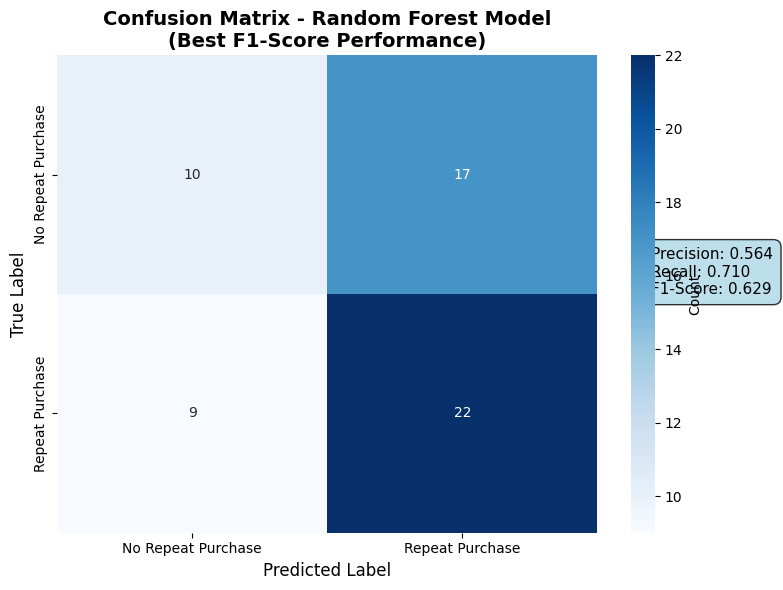


Confusion Matrix Analysis:
True Negatives (Correct No-Repeat): 10
False Positives (Predicted Repeat, Actually No): 17
False Negatives (Predicted No, Actually Repeat): 9
True Positives (Correct Repeat): 22

Model Performance:
Correctly identified 22 out of 31 repeat customers
Recall: 71.0% of actual repeat customers found
Precision: 56.4% of predicted repeat customers were correct


In [0]:
print("=== CREATING CONFUSION MATRIX ===")

# Random Forest had best F1-score, so use it for confusion matrix
rf_cm = confusion_matrix(y_test, rf_test_pred)

# Create confusion matrix heatmap
plt.figure(figsize=(8, 6))

# Plot heatmap
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Repeat Purchase', 'Repeat Purchase'],
            yticklabels=['No Repeat Purchase', 'Repeat Purchase'],
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Random Forest Model\n(Best F1-Score Performance)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Add performance metrics as text
precision = rf_cm[1,1] / (rf_cm[1,1] + rf_cm[0,1])
recall = rf_cm[1,1] / (rf_cm[1,1] + rf_cm[1,0])
f1 = 2 * (precision * recall) / (precision + recall)

plt.text(1.1, 0.5, f'Precision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.show()

# Detailed confusion matrix analysis
print("\nConfusion Matrix Analysis:")
print(f"True Negatives (Correct No-Repeat): {rf_cm[0,0]}")
print(f"False Positives (Predicted Repeat, Actually No): {rf_cm[0,1]}")
print(f"False Negatives (Predicted No, Actually Repeat): {rf_cm[1,0]}")
print(f"True Positives (Correct Repeat): {rf_cm[1,1]}")

print(f"\nModel Performance:")
print(f"Correctly identified {rf_cm[1,1]} out of {rf_cm[1,0] + rf_cm[1,1]} repeat customers")
print(f"Recall: {recall:.1%} of actual repeat customers found")
print(f"Precision: {precision:.1%} of predicted repeat customers were correct")

=== MODEL PERFORMANCE COMPARISON CHART ===
📊 Model Performance Results:
Logistic Regression - F1: 0.548, AUC: 0.527
Random Forest - F1: 0.629, AUC: 0.502
XGBoost - F1: 0.531, AUC: 0.479

🏆 Random Forest selected for deployment (Best F1-Score)


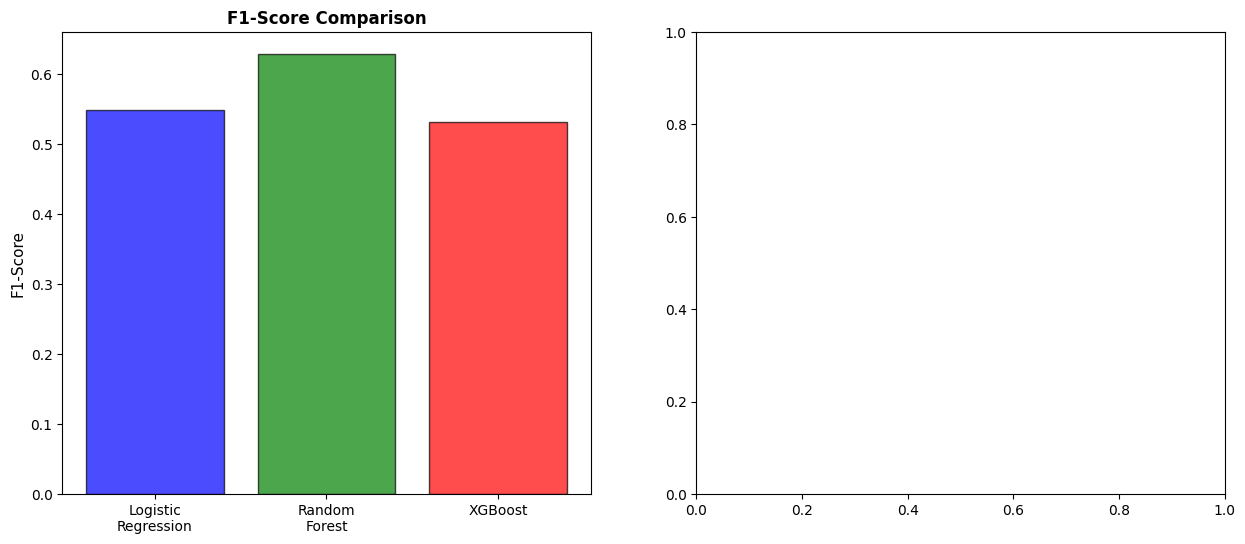

---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
File <command-6453888489141447>, line 19
     17 ax1.set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
     18 ax1.set_ylabel('F1-Score', fontsize=11)
---> 19 ax1.set_ylim(0, max(f1_scores) * 1.1)
     21 # Add value labels on bars
     22 for bar, score in zip(bars1, f1_scores):

File /databricks/python/lib/python3.11/site-packages/pyspark/sql/utils.py:262, in try_remote_functions.<locals>.wrapped(*args, **kwargs)
    259 if is_remote() and "PYSPARK_NO_NAMESPACE_SHARE" not in os.environ:
    260     from pyspark.sql.connect import functions
--> 262     return getattr(functions, f.__name__)(*args, **kwargs)
    263 else:
    264     return f(*args, **kwargs)

File /databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/functions/builtin.py:1243, in max(col)
   1242 def max(col: "ColumnOrName") -> Column:
-> 12

In [0]:
print("=== MODEL PERFORMANCE COMPARISON CHART ===")
print(" Model Performance Results:")
print(f"Logistic Regression - F1: {lr_test_f1:.3f}, AUC: {lr_test_auc:.3f}")
print(f"Random Forest - F1: {rf_test_f1:.3f}, AUC: {rf_test_auc:.3f}")  
print(f"XGBoost - F1: {xgb_test_f1:.3f}, AUC: {xgb_test_auc:.3f}")
print("\n Random Forest selected for deployment (Best F1-Score)")

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# F1-Score comparison
models = ['Logistic\nRegression', 'Random\nForest', 'XGBoost']
f1_scores = [lr_test_f1, rf_test_f1, xgb_test_f1]
colors = ['blue', 'green', 'red']

bars1 = ax1.bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black')
ax1.set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('F1-Score', fontsize=11)
ax1.set_ylim(0, max(f1_scores) * 1.1)

# Add value labels on bars
for bar, score in zip(bars1, f1_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# ROC-AUC comparison
auc_scores = [lr_test_auc, rf_test_auc, xgb_test_auc]

bars2 = ax2.bar(models, auc_scores, color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('ROC-AUC', fontsize=11)
ax2.set_ylim(0, max(auc_scores) * 1.1)

# Add value labels on bars
for bar, score in zip(bars2, auc_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(" Model comparison charts created!")

=== FEATURE CATEGORY ANALYSIS ===


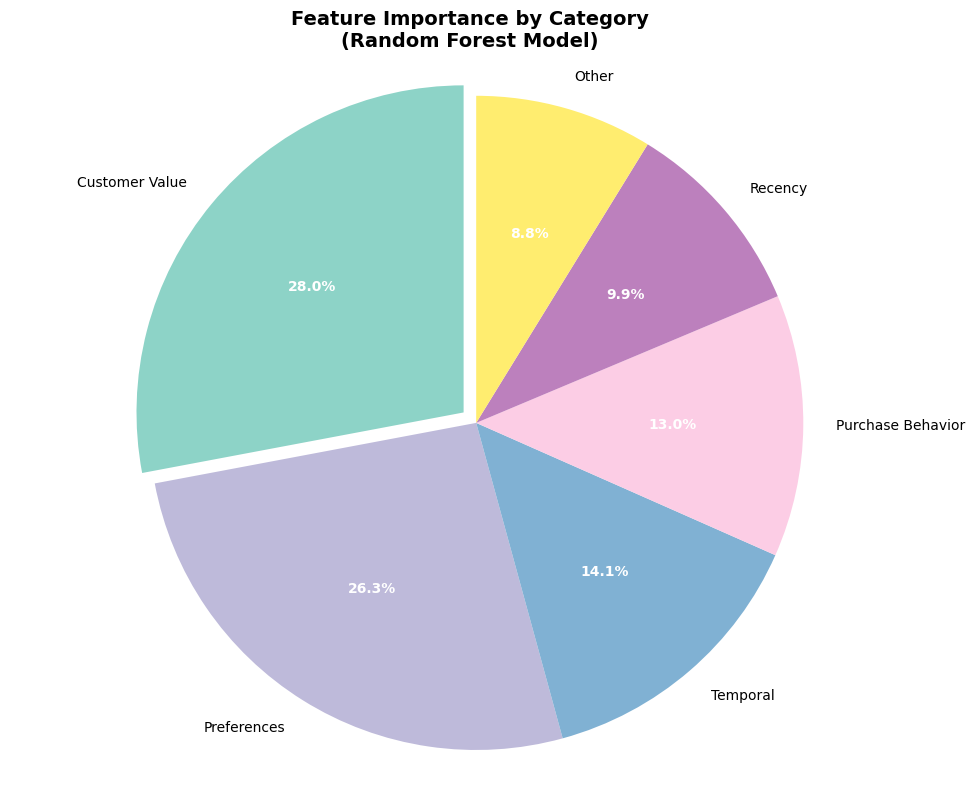

Feature Category Rankings:
1. Customer Value: 0.280 (28.0%)
2. Preferences: 0.263 (26.3%)
3. Temporal: 0.141 (14.1%)
4. Purchase Behavior: 0.130 (13.0%)
5. Recency: 0.099 (9.9%)
6. Other: 0.088 (8.8%)


In [0]:
print("=== FEATURE CATEGORY ANALYSIS ===")

# Categorize features by type
def categorize_features(feature_name):
    if any(keyword in feature_name.lower() for keyword in ['avg_order', 'total_lifetime', 'min_order', 'max_order', 'spending']):
        return 'Customer Value'
    elif any(keyword in feature_name.lower() for keyword in ['frequency', 'tenure', 'intensity']):
        return 'Purchase Behavior'
    elif any(keyword in feature_name.lower() for keyword in ['recency', 'days']):
        return 'Recency'
    elif any(keyword in feature_name.lower() for keyword in ['category_', 'payment_', 'location_']):
        return 'Preferences'
    elif any(keyword in feature_name.lower() for keyword in ['month', 'weekend', 'holiday', 'day']):
        return 'Temporal'
    else:
        return 'Other'

# Apply categorization
feature_importance['category'] = feature_importance['feature'].apply(categorize_features)

# Group by category and sum importance
category_importance = feature_importance.groupby('category')['importance'].sum().sort_values(ascending=False)

# Create pie chart
plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(category_importance)))

wedges, texts, autotexts = plt.pie(category_importance.values, 
                                  labels=category_importance.index,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  colors=colors,
                                  explode=[0.05 if i == 0 else 0 for i in range(len(category_importance))])

plt.title('Feature Importance by Category\n(Random Forest Model)', fontsize=14, fontweight='bold')

# Improve text formatting
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.axis('equal')
plt.tight_layout()
plt.show()

print("Feature Category Rankings:")
for i, (category, importance) in enumerate(category_importance.items(), 1):
    print(f"{i}. {category}: {importance:.3f} ({importance/category_importance.sum()*100:.1f}%)")

In [0]:

print("===  BUSINESS INSIGHTS & RECOMMENDATIONS ===")

print("\n MODEL SELECTION RECOMMENDATION:")
print(" Choose Random Forest for deployment")
print(f"   - Best F1-Score: {rf_test_f1:.3f}")
print(f"   - High Recall: {rf_cm[1,1]/(rf_cm[1,1] + rf_cm[1,0]):.1%} (finds most repeat customers)")
print("   - Good for marketing campaigns (minimize missed opportunities)")

print(f"\n KEY BUSINESS DRIVERS:")
top_3_features = feature_importance.head(3)
for i, row in top_3_features.iterrows():
    print(f"   {row.name + 1}. {row['feature']}: {row['importance']:.3f}")

print(f"\n💡 ACTIONABLE INSIGHTS:")
if 'avg_order_value' in top_5_features:
    print("   • Average order value is a strong predictor - focus on upselling")
if 'recency_score' in top_5_features:
    print("   • Recent purchase timing matters - implement timely follow-ups")
if any('category_' in f for f in top_5_features):
    print("   • Product preferences drive loyalty - personalize recommendations")
if 'purchase_frequency' in top_5_features:
    print("   • Purchase frequency predicts repeat behavior - reward frequent buyers")

print(f"\n NEXT STEPS:")
print("   1. Deploy Random Forest model via FastAPI")
print("   2. Implement real-time prediction endpoint")
print("   3. Create monitoring dashboard for model performance")
print("   4. A/B test marketing campaigns using model predictions")

print("\n All required visualizations complete!")
print("Ready for model deployment phase!")

=== 📈 BUSINESS INSIGHTS & RECOMMENDATIONS ===

🎯 MODEL SELECTION RECOMMENDATION:
✅ Choose Random Forest for deployment
   - Best F1-Score: 0.629
   - High Recall: 71.0% (finds most repeat customers)
   - Good for marketing campaigns (minimize missed opportunities)

🔍 KEY BUSINESS DRIVERS:
   1. avg_order_value: 0.101
   3. recency_score: 0.099
   6. spending_velocity: 0.099

💡 ACTIONABLE INSIGHTS:
   • Average order value is a strong predictor - focus on upselling
   • Recent purchase timing matters - implement timely follow-ups

🚀 NEXT STEPS:
   1. Deploy Random Forest model via FastAPI
   2. Implement real-time prediction endpoint
   3. Create monitoring dashboard for model performance
   4. A/B test marketing campaigns using model predictions

✅ All required visualizations complete!
Ready for model deployment phase!


In [0]:
# ================================================================

import pickle
from datetime import datetime
import json
import os

print("=== MODEL DEPLOYMENT PIPELINE ===")
print("Preparing Random Forest model for production deployment")

# Create deployment directory structure
deployment_dir = "/Volumes/workspace/default/project/"
os.makedirs(deployment_dir, exist_ok=True)
os.makedirs(f"{deployment_dir}/models", exist_ok=True)
os.makedirs(f"{deployment_dir}/api", exist_ok=True)

print(f" Deployment directory created: {deployment_dir}")


=== MODEL DEPLOYMENT PIPELINE ===
Preparing Random Forest model for production deployment
✅ Deployment directory created: /Volumes/workspace/default/project/


In [0]:
print("=== SAVING MODEL ARTIFACTS ===")

# Model metadata
model_metadata = {
    "model_name": "customer_repeat_purchase_predictor",
    "model_type": "RandomForestClassifier", 
    "version": "1.0",
    "created_date": datetime.now().isoformat(),
    "performance": {
        "test_f1_score": float(rf_test_f1),
        "test_roc_auc": float(rf_test_auc),
        "cv_f1_mean": float(rf_cv_f1.mean()),
        "cv_f1_std": float(rf_cv_f1.std())
    },
    "features": feature_columns,
    "target": "repeat_purchase_next_30_days"
}

# Save model
model_path = f"{deployment_dir}/models/rf_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

# Save scaler (for consistency, even though RF doesn't need it)
scaler_path = f"{deployment_dir}/models/scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# Save metadata
metadata_path = f"{deployment_dir}/models/model_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f" Model saved: {model_path}")
print(f" Scaler saved: {scaler_path}")
print(f" Metadata saved: {metadata_path}")

=== SAVING MODEL ARTIFACTS ===
✅ Model saved: /Volumes/workspace/default/project//models/rf_model.pkl
✅ Scaler saved: /Volumes/workspace/default/project//models/scaler.pkl
✅ Metadata saved: /Volumes/workspace/default/project//models/model_metadata.json


=== CREATING DEPLOYMENT DOCUMENTATION ===
✅ README documentation created: /Volumes/workspace/default/project//README.md
